# STAT 301 Project Planning Stage 
### Group 3, Eric Yee

## Data Description

The assigned diabetes dataset contains 768 observations, each representing a patient, with eight predictor variables and one response variable. The data comes from The National Institute of Diabetes and Digestive and Kidney Diseases. All patients are female, at least 21 years old, and of Pima Indian heritage. These observations are independent, as time is not a variable.

The nine variables for each patient include:
|Label                   |Description|
|------------------------|---------------|
|Pregnancies             |Number of pregnancies|
|Glucose                 |Glucose level in blood|
|BloodPressure           |Measured blood pressure|
|SkinThickness           |Thickness of skin|
|Insulin                 |Level of insulin in blood|
|BMI                     |Body Mass Index|
|DiabetesPedigreeFunction|Diabetes percentage|
|Age                     |Age in years|
|Outcome                 |Whether diabetes is present|

The first eight rows are predictor variables, while the last one is the response.

## Question

The question we will try to answer with the dataset will be:
> Is it possible to tell whether a patient has diabetes based on their glucose and insulin levels?

Each observation in our dataset has the patient's glucose levels, insulin levels, and whether they have diabetes, allowing us to build a logistic regression model out of these variables with diabetes as the response variable. Our question focuses on both inference to find if a relation exists and prediction to see if our model can predict the response variable of new observations. Glucose and insulin were chosen since diabetes is often characterized by high blood sugar and low insulin levels.

## Exploratory Data Analysis and Visualization

In [1]:
library(tidyverse)
library(repr)
library(broom)
library(leaps)
library(moderndive)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
diabetes <- read.csv("diabetes.csv")

In [3]:
head(diabetes)
tail(diabetes)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 6           148     72            35              0     33.6
2 1            85     66            29              0     26.6
3 8           183     64             0              0     23.3
4 1            89     66            23             94     28.1
5 0           137     40            35            168     43.1
6 5           116     74             0              0     25.6
  DiabetesPedigreeFunction Age Outcome
1 0.627                    50  1      
2 0.351                    31  0      
3 0.672                    32  1      
4 0.167                    21  0      
5 2.288                    33  1      
6 0.201                    30  0

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
763  9           89     62             0              0     22.5
764 10          101     76            48            180     32.9
765  2          122     70            27              0     36.8
766  5          121     72            23            112     26.2
767  1          126     60             0              0     30.1
768  1           93     70            31              0     30.4
    DiabetesPedigreeFunction Age Outcome
763 0.142                    33  0      
764 0.171                    63  0      
765 0.340                    27  0      
766 0.245                    30  0      
767 0.349                    47  1      
768 0.315                    23  0

In [4]:
dim(diabetes)

[1] 768   9

In [5]:
diabetes$Outcome <- as.factor(diabetes$Outcome)

In [6]:
diabetes_long <- diabetes |>
    select(-Outcome) |>
    gather(factor_key = TRUE, key = "variable")
head(diabetes_long)

variable    value
1 Pregnancies 6    
2 Pregnancies 1    
3 Pregnancies 8    
4 Pregnancies 1    
5 Pregnancies 0    
6 Pregnancies 5

In [7]:
diabetes_stats <-
    diabetes_long |>
    group_by(variable) |>
    summarize(mean = mean(value),
              sd = sd(value),
              max = max(value),
              min = min(value))
diabetes_stats

variable                 mean        sd          max    min   
1 Pregnancies                3.8450521   3.3695781  17.00  0.000
2 Glucose                  120.8945312  31.9726182 199.00  0.000
3 BloodPressure             69.1054688  19.3558072 122.00  0.000
4 SkinThickness             20.5364583  15.9522176  99.00  0.000
5 Insulin                   79.7994792 115.2440024 846.00  0.000
6 BMI                       31.9925781   7.8841603  67.10  0.000
7 DiabetesPedigreeFunction   0.4718763   0.3313286   2.42  0.078
8 Age                       33.2408854  11.7602315  81.00 21.000

Having a glucose or insulin level of 0 doesn't make sense, so they were probably just not recorded for these observations. We will remove these observations for the model.

In [8]:
# Observations with a glucose value of 0
glucose_0 <- 
    diabetes |>
    filter(Glucose == 0) 
head(glucose_0)
dim(glucose_0)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 1           0       48            20             0      24.7
2 1           0       74            20            23      27.7
3 1           0       68            35             0      32.0
4 5           0       80            32             0      41.0
5 6           0       68            41             0      39.0
  DiabetesPedigreeFunction Age Outcome
1 0.140                    22  0      
2 0.299                    21  0      
3 0.389                    22  0      
4 0.346                    37  1      
5 0.727                    41  1

[1] 5 9

In [9]:
# Observations with an insulin value of 0
insulin_0 <- 
    diabetes |>
    filter(Insulin == 0) 
head(insulin_0)
dim(insulin_0)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1  6          148     72            35            0       33.6
2  1           85     66            29            0       26.6
3  8          183     64             0            0       23.3
4  5          116     74             0            0       25.6
5 10          115      0             0            0       35.3
6  8          125     96             0            0        0.0
  DiabetesPedigreeFunction Age Outcome
1 0.627                    50  1      
2 0.351                    31  0      
3 0.672                    32  1      
4 0.201                    30  0      
5 0.134                    29  0      
6 0.232                    54  1

[1] 374   9

In [10]:
diabetes_trim <-
    diabetes |>
    filter(Glucose != 0 & Insulin != 0)
head(diabetes_trim)
dim(diabetes_trim)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 1            89     66            23             94     28.1
2 0           137     40            35            168     43.1
3 3            78     50            32             88     31.0
4 2           197     70            45            543     30.5
5 1           189     60            23            846     30.1
6 5           166     72            19            175     25.8
  DiabetesPedigreeFunction Age Outcome
1 0.167                    21  0      
2 2.288                    33  1      
3 0.248                    26  1      
4 0.158                    53  1      
5 0.398                    59  1      
6 0.587                    51  1

[1] 393   9

Our model won't provide accurate standard errors if there's multicollinearity, so we'll check for that now.

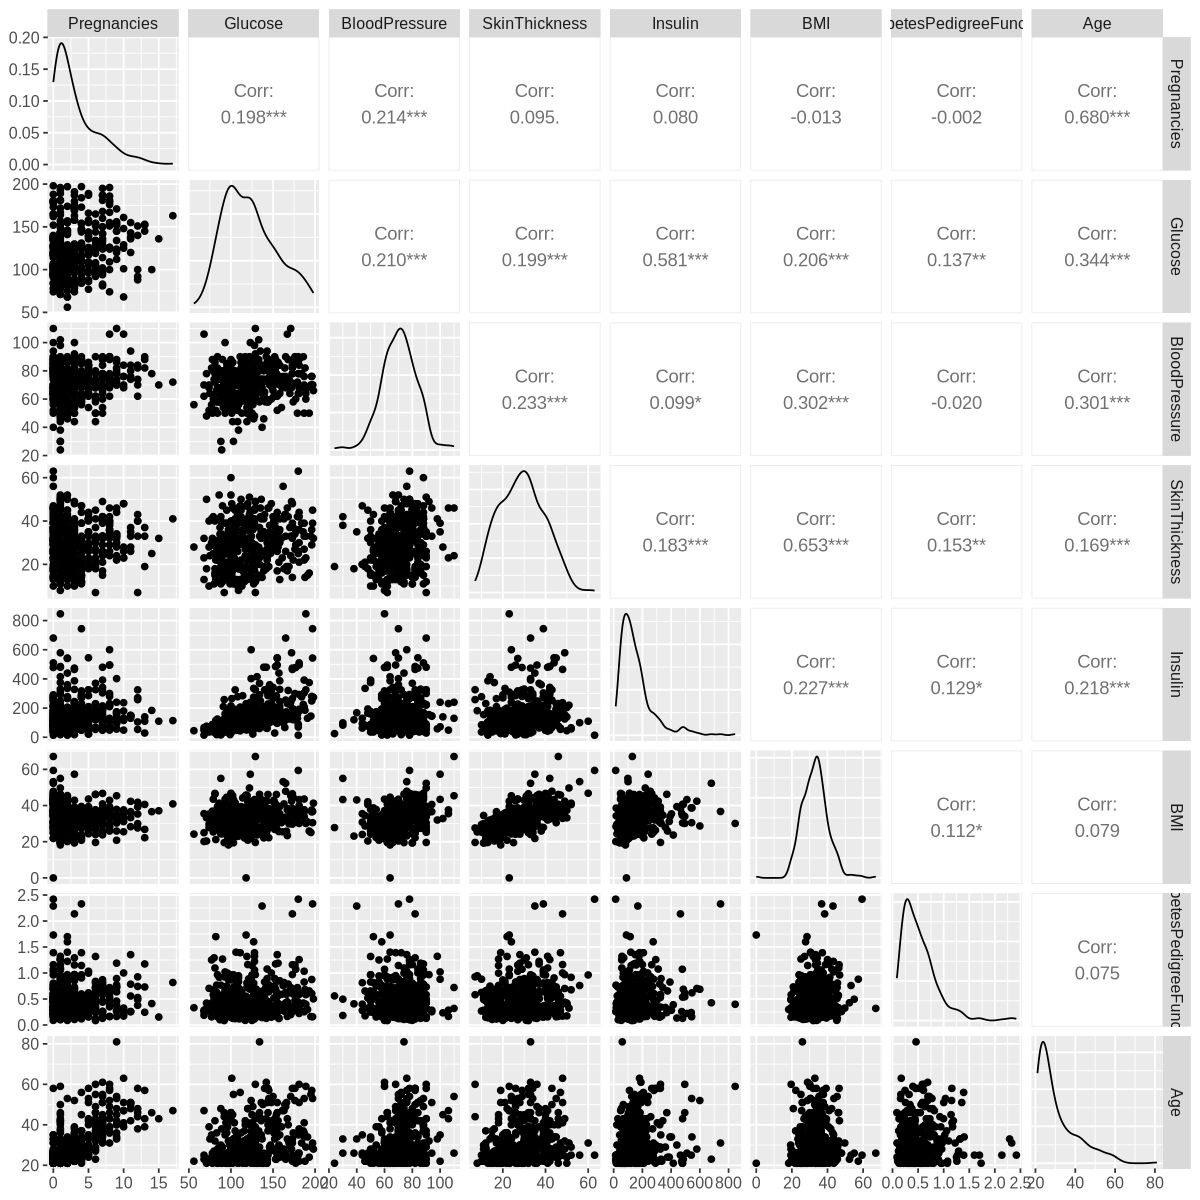

In [11]:
# Check for multicollinearity
options(repr.plot.width = 10, repr.plot.height = 10) 
diabetes_pair_plots <-
    diabetes_trim |>
    select(-Outcome) |>
    ggpairs(progress = FALSE) +
    theme(text = element_text(size = 12))
diabetes_pair_plots

The highest correlation of 0.680 is between `Age` and `Pregnancies`, which is high, but we aren't planning to use them in the model anyways. `Insulin` and `Glucose` have a correlation of 0.581 which is somehwat high, but it's not quite high enough to conclude multicollinearity.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


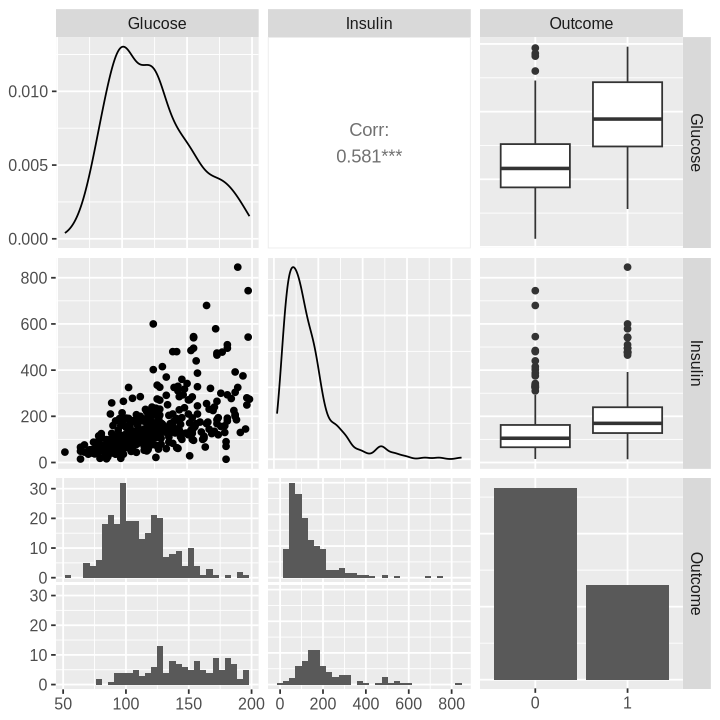

In [12]:
# Check correlation between inputs and response
options(repr.plot.width = 6, repr.plot.height = 6) 
input_pair_plots <-
    diabetes_trim |>
    select(Glucose, Insulin, Outcome) |>
    ggpairs(progress = FALSE) +
    theme(text = element_text(size = 12))
input_pair_plots

The boxplots show that both input variables are positively correlated with the response variable, which is somewhat unexpected as low insulin levels are typically associated with diabetes.

In [13]:
diabetes_clean <-
    diabetes_trim |>
    drop_na() |>
    select(Glucose, Insulin, Outcome) 
head(diabetes_clean)

Glucose Insulin Outcome
1  89      94     0      
2 137     168     1      
3  78      88     1      
4 197     543     1      
5 189     846     1      
6 166     175     1

## Methods and Plan

Since we are trying to predict a binary outcome, it makes the most sense to use a logistic regression model so that we don't run into any range issues. We will make it a model with interaction, as we anticipate that glucose and insulin interact with the response differently. 

This model assumes that the response is binary, observations are independent, and that there is no multicollinearity in the input variables. We see from our data analysis that these are true. A weakness to this model is that there is assumed to be a linear boundary between classifaction levels in the data.

Since our plan is to use only two of the eight input variables, confounding variables may not be considered. We'll assess whether these two variables are statistically significant in predicting if a patient has diabetes, and explore using other covariates if we find that a model with only these two covariates does not have good out-of-sample test performance.